In [30]:
!pip install fair-esm torch scikit-learn pandas

                                    mutated_sequence  mean_rate
0  HNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.621630
1  KNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.579141
2  RNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.828325
3  DNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.344291
4  ENFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.336618
         mean_rate
count  5201.000000
mean      0.232856
std       0.145747
min       0.000000
25%       0.102703
50%       0.230244
75%       0.344291
max       1.000000
mutated_sequence    0
mean_rate           0
dtype: int64


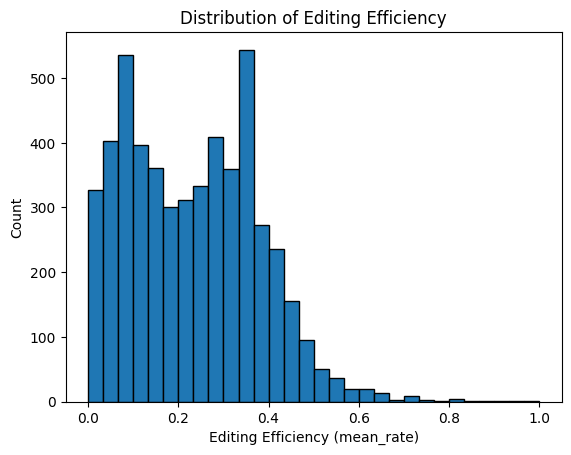

In [31]:
import pandas as pd

df = pd.read_csv("data/adar2_mutated_sequences.csv")

print(df.head())

print(df.describe())

print(df.isnull().sum())
import matplotlib.pyplot as plt

plt.hist(df["mean_rate"], bins=30, edgecolor="black")
plt.xlabel("Editing Efficiency (mean_rate)")
plt.ylabel("Count")
plt.title("Distribution of Editing Efficiency")
plt.show()


In [32]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Load the ADAR2 dataset
df = pd.read_csv(r"data/adar2_mutated_sequences.csv")
print(df.head())

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ESM2 model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(device)
model.eval()




import numpy as np
import time
from tqdm import tqdm

def embed_sequences_transformers(sequences, batch_size=8, cache_path=None):
    """
    Compute mean embeddings per sequence using HuggingFace Transformers ESM2.
    """
    all_embeddings = []
    num_batches = (len(sequences) + batch_size - 1) // batch_size

    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), total=num_batches, desc="Embedding batches"):
           
            batch = sequences[i:i+batch_size]
            encoded_inputs = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                add_special_tokens=True
            )
            input_ids = encoded_inputs["input_ids"].to(device)
            attention_mask = encoded_inputs["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )

            hidden_states = outputs.last_hidden_state

            # Masked mean pooling
            mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
            summed = torch.sum(hidden_states * mask, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / counts

            all_embeddings.append(mean_pooled.cpu().numpy())

            
    embeddings = np.vstack(all_embeddings)

    if cache_path:
        np.save(cache_path, embeddings)
        print(f"Saved embeddings to {cache_path}")

    return np.vstack(all_embeddings)





                                    mutated_sequence  mean_rate
0  HNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.621630
1  KNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.579141
2  RNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.828325
3  DNFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.344291
4  ENFSSPHARRKVLAGVVMTTGTDVKDAKVISVSTGTKCINGEYMSD...   0.336618
Using device: cuda


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
df = pd.read_csv("data/adar2_mutated_sequences.csv")
sequences_subset = df["mutated_sequence"].tolist()  # first 2 sequences
import os
# ===============================
# 2. Embed and save to file
# ===============================
esm_cache_path = "embeddings/adar2_esm2_second_try.npy"
if not os.path.exists(esm_cache_path):
    print(f"Loading cached embeddings from {esm_cache_path}")
    X_subset = np.load(esm_cache_path)
    X_subset = embed_sequences_transformers(sequences_subset, cache_path=esm_cache_path)
else:
    X_subset = np.load(esm_cache_path)
print("Shape of embedded array:", X_subset.shape)

Shape of embedded array: (5201, 320)


In [34]:
import esm
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load data
df = pd.read_csv("data/adar2_mutated_sequences.csv")
sequences = df["mutated_sequence"].tolist()

# Load pretrained ESM2 model and alphabet
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_converter = alphabet.get_batch_converter()

def embed_sequences_esm2(sequences, batch_size=8):
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="Embedding batches"):
            batch_seqs = sequences[i:i+batch_size]
            batch_labels_and_seqs = [(str(idx), seq) for idx, seq in enumerate(batch_seqs)]
            labels, seqs, tokens = batch_converter(batch_labels_and_seqs)
            tokens = tokens.to(device)
            
            # Get representations from layer 6 (you can try other layers)
            results = model(tokens, repr_layers=[6])
            token_reps = results["representations"][6]

            # Mean pool over tokens (excluding start/end tokens)
            embeddings = token_reps[:, 1:-1].mean(1)

            all_embeddings.append(embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

# Generate embeddings
embed_path = "embeddings/adar2_esm2_embeddings.npy"
import os
if not os.path.exists(embed_path):
    embeddings = embed_sequences_esm2(sequences, batch_size=8)
    print("Embeddings shape:", embeddings.shape)  # Should be (N, 320) for esm2_t6_8M_UR50D
    # Save embeddings to file
    np.save(embed_path, embeddings)
    print("Embeddings saved to", embed_path)
else:
    embeddings = np.load(embed_path)
    print("Loaded existing embeddings from", embed_path)


Loaded existing embeddings from embeddings/adar2_esm2_embeddings.npy


# ONE HOT


In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
import os
# -------------------------------------------------------------
# 1. Train/Test Split
# -------------------------------------------------------------
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# -------------------------------------------------------------
# 2. Train and Save Models
# -------------------------------------------------------------
def train_and_save_models(X_train, y_train, save_prefix="model"):
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
        "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=1000, random_state=42)
    }
    
    for name, model in models.items():
        filename = f"{save_prefix}_{name}.joblib"
        if os.path.exists(filename):
            print(f"⚠️  {name} already exists at {filename}, skipping training.")
        else:
            print(f"🔹 Training {name}...")
            model.fit(X_train, y_train)
            joblib.dump(model, f"{save_prefix}_{name}.joblib")
            print(f"✅ {name} saved to {save_prefix}_{name}.joblib")
    return models.keys()

# -------------------------------------------------------------
# 3. Load Models
# -------------------------------------------------------------
def load_models(model_names, save_prefix="model"):
    loaded = {}
    for name in model_names:
        loaded[name] = joblib.load(f"{save_prefix}_{name}.joblib")
        print(f"🔹 Loaded {name}")
    return loaded

# -------------------------------------------------------------
# 4. Evaluate Models
# -------------------------------------------------------------
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        r2_train = r2_score(y_train, y_pred_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        print(f"\n{name}:")
        print(f"  Train R² = {r2_train:.3f}, MSE = {mse_train:.4f}")
        print(f"  Test  R² = {r2_test:.3f}, MSE = {mse_test:.4f}")
        results[name] = {
            "y_train": y_pred_train,
            "y_test": y_pred_test
        }
    return results

# -------------------------------------------------------------
# 5. Visualize Results
# -------------------------------------------------------------
def plot_results(y_train, y_test, results):
    plt.figure(figsize=(18, 6))
    for i, (name, preds) in enumerate(results.items()):
        # Train
        plt.subplot(2, len(results), i + 1)
        plt.scatter(y_train, preds["y_train"], alpha=0.6, color="blue", label="Train")
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "k--")
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"{name} Train")
        plt.grid(True)
        plt.legend()
        # Test
        plt.subplot(2, len(results), i + 1 + len(results))
        plt.scatter(y_test, preds["y_test"], alpha=0.6, color="orange", label="Test")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"{name} Test")
        plt.grid(True)
        plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
import numpy as np

AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa: idx for idx, aa in enumerate(AMINO_ACIDS)}

def one_hot_encode(seq, max_len):
    encoding = np.zeros((max_len, len(AMINO_ACIDS)), dtype=np.float32)
    for i, aa in enumerate(seq):
        if i >= max_len:
            break
        if aa in aa_to_idx:
            encoding[i, aa_to_idx[aa]] = 1.0
    return encoding

def embed_sequences_onehot(sequences, cache_path=None):
    max_len = max(len(s) for s in sequences)
    embeddings = []
    for seq in sequences:
        oh = one_hot_encode(seq, max_len)
        mean_pooled = oh.mean(axis=0)
        embeddings.append(mean_pooled)
    if cache_path:
        np.save(cache_path, embeddings)
        print(f"Saved one-hot encoded  sequences to {cache_path}")

        
    return np.vstack(embeddings)


import pandas as pd

df = pd.read_csv("data/adar2_mutated_sequences.csv")
sequences = df["mutated_sequence"].tolist()
y = df["mean_rate"].values
onehot_path = "embeddings/adar2_onehot_cache.npy"
X = embed_sequences_onehot(sequences, cache_path=onehot_path)






Saved one-hot encoded  sequences to embeddings/adar2_onehot_cache.npy


Train shape: (4160, 20), Test shape: (1041, 20)
Train shape: (5201, 2)
Train shape: (5201, 20)
Train shape: (4160, 20)
Test shape: (1041, 20)
⚠️  RandomForest already exists at models/onehot_adar2_RandomForest.joblib, skipping training.
⚠️  XGBoost already exists at models/onehot_adar2_XGBoost.joblib, skipping training.
⚠️  MLP already exists at models/onehot_adar2_MLP.joblib, skipping training.
🔹 Loaded RandomForest
🔹 Loaded XGBoost
🔹 Loaded MLP

RandomForest:
  Train R² = 0.273, MSE = 0.0153
  Test  R² = 0.129, MSE = 0.0190

XGBoost:
  Train R² = 0.255, MSE = 0.0157
  Test  R² = 0.142, MSE = 0.0187

MLP:
  Train R² = -0.001, MSE = 0.0211
  Test  R² = 0.000, MSE = 0.0218


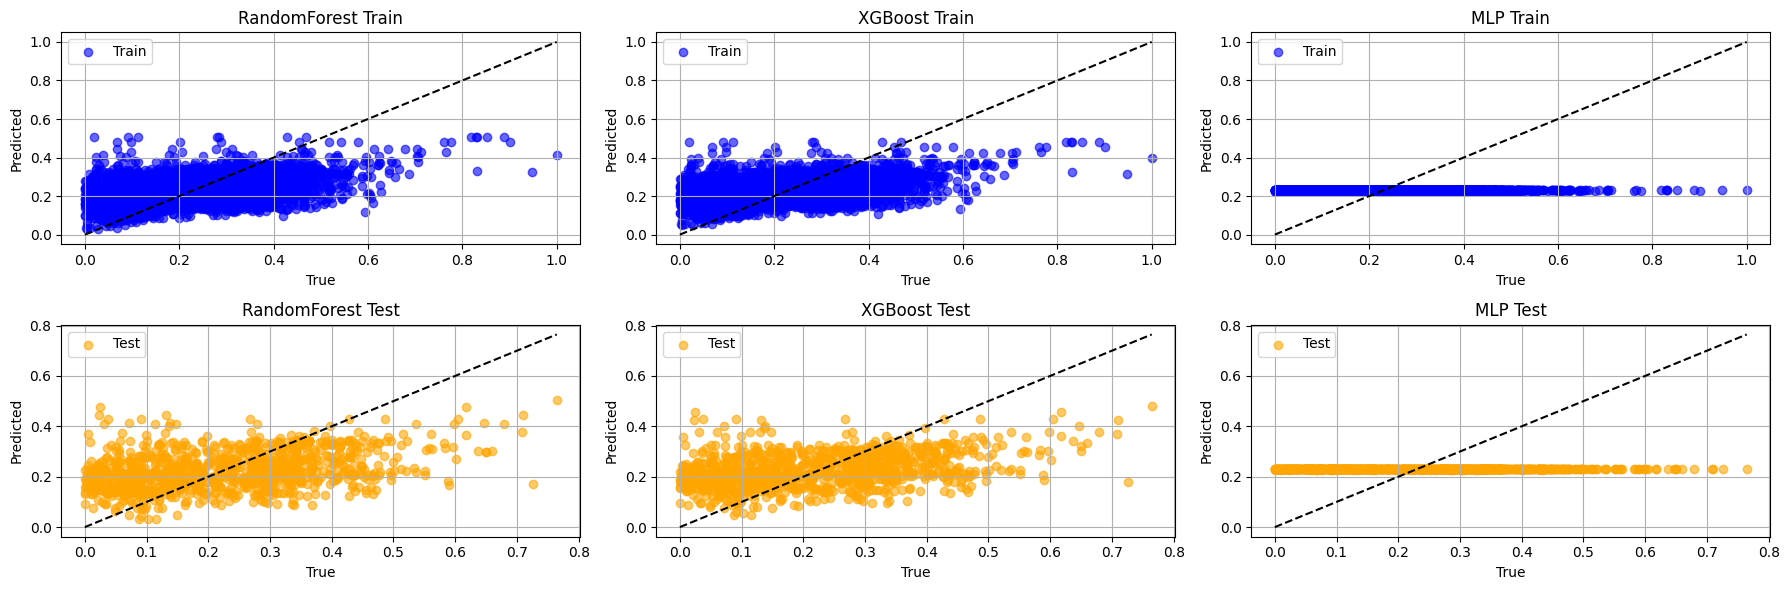

In [37]:
# Load your embeddings
X = np.load("embeddings/adar2_onehot_cache.npy")
df = pd.read_csv("data/adar2_mutated_sequences.csv")
y = df["mean_rate"].values

# Split
X_train, X_test, y_train, y_test = split_data(X, y)
print("Train shape:", df.shape)
print("Train shape:", X.shape)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

model_names = train_and_save_models(X_train, y_train, save_prefix="models/onehot_adar2")
loaded_models = load_models(model_names, save_prefix="models/onehot_adar2")

results = evaluate_models(loaded_models, X_train, y_train, X_test, y_test)

# Visualize
plot_results(y_train, y_test, results)



# ESM embeddings

In [38]:
# Load your embeddings
X = np.load("embeddings/adar2_esm2_embeddings.npy")
df = pd.read_csv("data/adar2_mutated_sequences.csv")
y = df["mean_rate"].values

# Split
X_train, X_test, y_train, y_test = split_data(X, y)



Train shape: (4160, 320), Test shape: (1041, 320)


In [39]:

model_names = train_and_save_models(X_train, y_train, save_prefix="models/esm_adar2")


⚠️  RandomForest already exists at models/esm_adar2_RandomForest.joblib, skipping training.
⚠️  XGBoost already exists at models/esm_adar2_XGBoost.joblib, skipping training.
⚠️  MLP already exists at models/esm_adar2_MLP.joblib, skipping training.


🔹 Loaded RandomForest
🔹 Loaded XGBoost
🔹 Loaded MLP

RandomForest:
  Train R² = 0.907, MSE = 0.0020
  Test  R² = 0.386, MSE = 0.0134

XGBoost:
  Train R² = 0.977, MSE = 0.0005
  Test  R² = 0.460, MSE = 0.0117

MLP:
  Train R² = 0.114, MSE = 0.0187
  Test  R² = 0.114, MSE = 0.0193


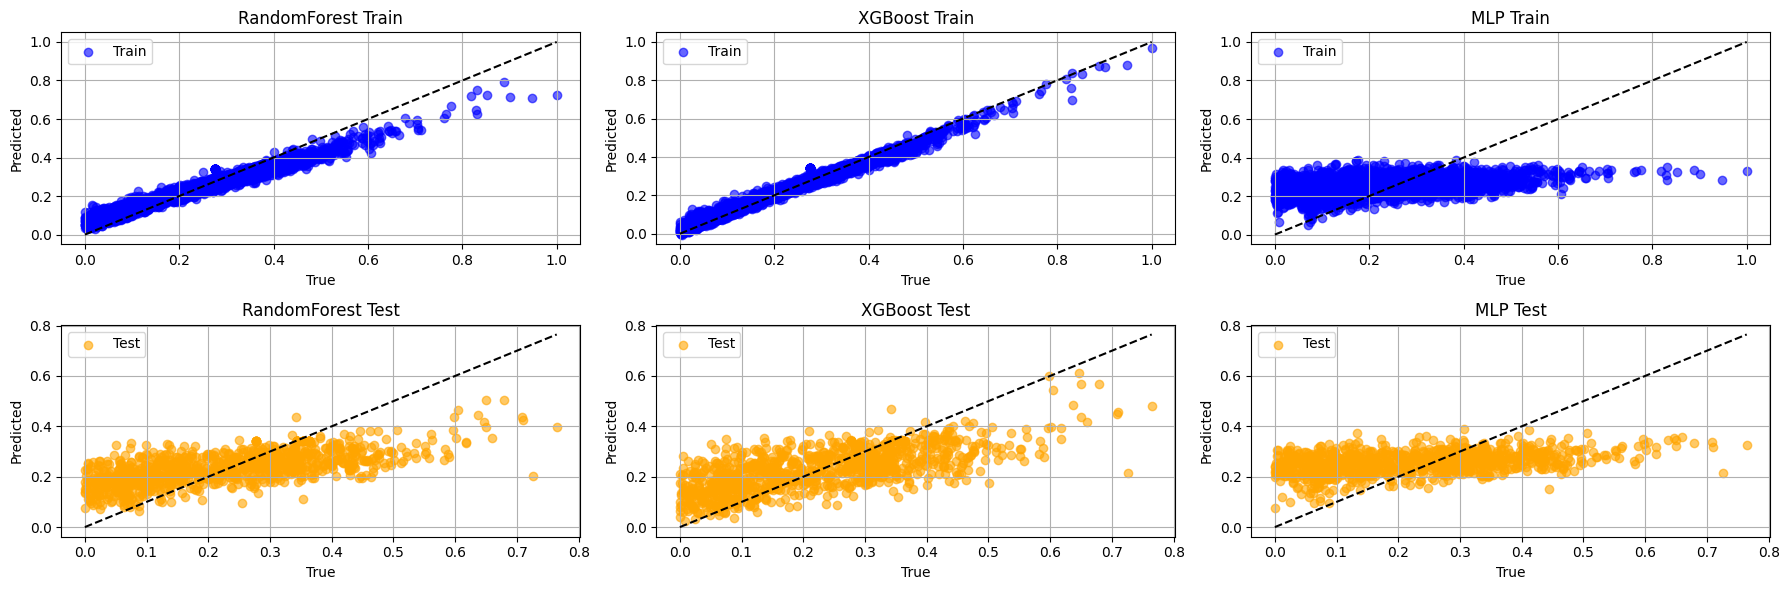

In [40]:


loaded_models = load_models(model_names, save_prefix="models/esm_adar2")

results = evaluate_models(loaded_models, X_train, y_train, X_test, y_test)

# Visualize
plot_results(y_train, y_test, results)


# bert

In [41]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Load ProtBert tokenizer and model once
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")
model.eval()  # set to eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def embed_sequences_bert(sequences, cache_path=None, batch_size=64):
    """
    Embed a list of sequences using ProtBert.
    Returns a numpy array of shape (num_sequences, embedding_dim).
    """
    all_embeddings = []

    # Process in batches
    for i in tqdm(range(0, len(sequences), batch_size), desc="Embedding batches"):
        batch_seqs = sequences[i:i+batch_size]

        # ProtBert expects space-separated letters
        formatted = [" ".join(list(seq)) for seq in batch_seqs]

        # Tokenize
        inputs = tokenizer(formatted, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Embed
        with torch.no_grad():
            outputs = model(**inputs)

        # outputs.last_hidden_state: (batch_size, seq_len, hidden_size)
        embeddings = outputs.last_hidden_state

        # For each sequence in batch
        for j in range(embeddings.size(0)):
            # Exclude [CLS] and [SEP] tokens
            seq_emb = embeddings[j, 1:-1]
            # Mean pool over residues
            mean_pooled = seq_emb.mean(dim=0).cpu().numpy()
            all_embeddings.append(mean_pooled)

    all_embeddings = np.vstack(all_embeddings)

    if cache_path:
        np.save(cache_path, all_embeddings)
        print(f"Saved BERT embeddings to {cache_path}")

    return all_embeddings

# Example usage with pandas dataframe

import pandas as pd

df = pd.read_csv("data/adar2_mutated_sequences.csv")
sequences = df["mutated_sequence"].tolist()
y = df["mean_rate"].values


bert_cache_path = "embeddings/adar2_bert_cache.npy"
import os
if not os.path.exists(bert_cache_path):
    X = embed_sequences_bert(sequences, cache_path=bert_cache_path)
    print("Embeddings shape:", embeddings.shape)  # Should be (N, 320) for esm2    _t6_8M_UR50D
    # Save embeddings to file

    print("Embeddings saved to", bert_cache_path)
else:
    X = np.load(bert_cache_path)
    print("Loaded existing embeddings from", bert_cache_path)
    
print("Embeddings shape:", X.shape)


Loaded existing embeddings from embeddings/adar2_bert_cache.npy
Embeddings shape: (5201, 1024)


Train shape: (4160, 1024), Test shape: (1041, 1024)
⚠️  RandomForest already exists at models/bert_adar2_RandomForest.joblib, skipping training.
⚠️  XGBoost already exists at models/bert_adar2_XGBoost.joblib, skipping training.
⚠️  MLP already exists at models/bert_adar2_MLP.joblib, skipping training.
🔹 Loaded RandomForest
🔹 Loaded XGBoost
🔹 Loaded MLP

RandomForest:
  Train R² = 0.929, MSE = 0.0015
  Test  R² = 0.491, MSE = 0.0111

XGBoost:
  Train R² = 0.993, MSE = 0.0001
  Test  R² = 0.580, MSE = 0.0091

MLP:
  Train R² = 0.192, MSE = 0.0171
  Test  R² = 0.184, MSE = 0.0178


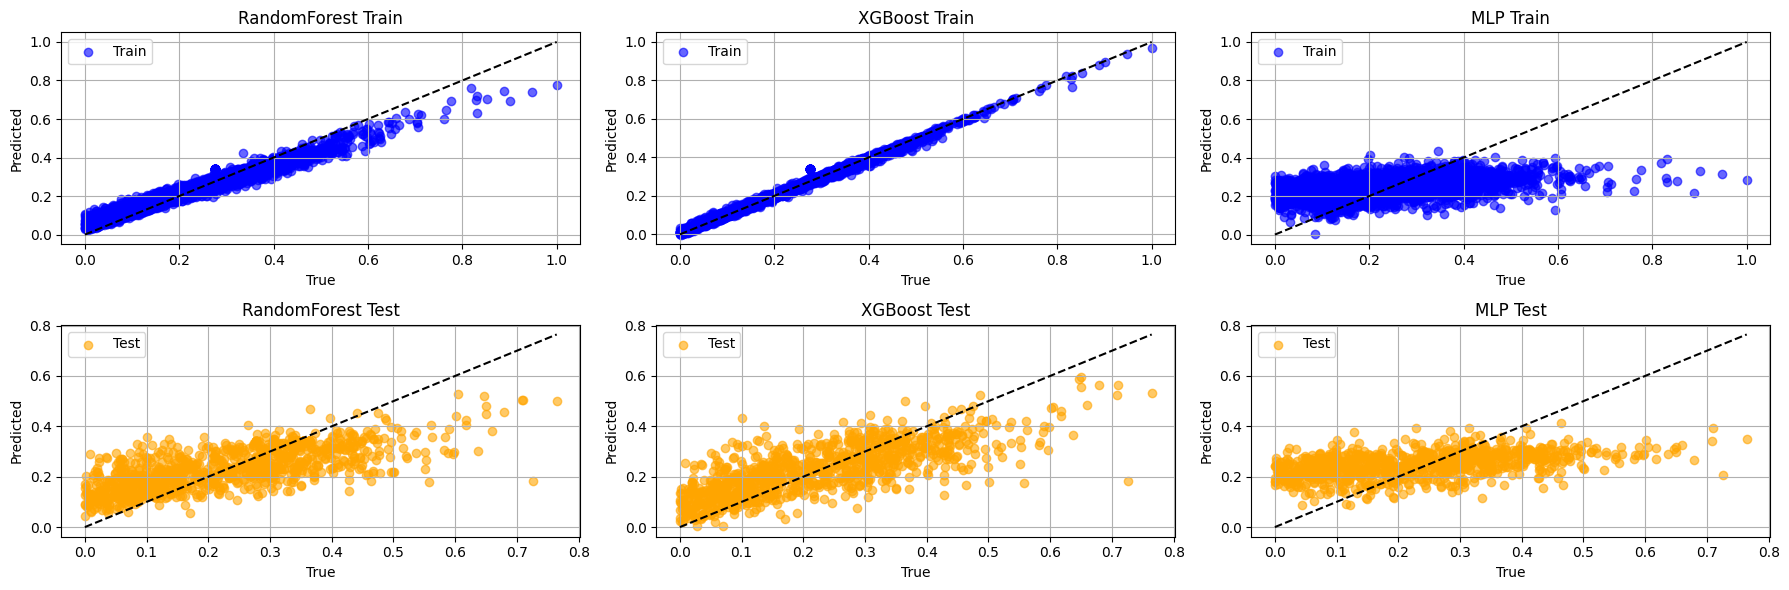

In [42]:
# Generate embeddings
# Load your embeddings
X = np.load("embeddings/adar2_bert_cache.npy")
df = pd.read_csv("data/adar2_mutated_sequences.csv")
y = df["mean_rate"].values

# Split
X_train, X_test, y_train, y_test = split_data(X, y)

model_names = train_and_save_models(X_train, y_train, save_prefix="models/bert_adar2")

loaded_models = load_models(model_names, save_prefix="models/bert_adar2")

results = evaluate_models(loaded_models, X_train, y_train, X_test, y_test)

# Visualize
plot_results(y_train, y_test, results)